<div style="border-radius:10px;border:#B7B7A4 solid;padding:15px;background-color:#2874A6;font-size:200%;text-align:left">
<a id=toc></a>
<h1 style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-size: 100% auto;background-position: 0px 0px; 
"><span style='color:white'><b> 🚀 Hyperparameter Tuning With Optuna</b></span></h1>


<div style="border-radius:10px;border:#B7B7A4 solid;padding:15px;background-color:#Model PerformanceModel Performance;font-size:110%;text-align:left">
    
<h2><span style="text-align:center; font-weight:bolder; color:navy">Table of Contents:</span></h2> 
<p>
    
<a id="toc"></a>
- [1. Import Libraries](#1)
- [2. Data Loading](#2)
- [3. Data Exploration](#3)
- [4. Data Processing](#4)
- [5. Model Building](#5)
- [6. Finding Best Paramaters with Optuna](#6)
- [7. Rebuilding Model With Optimized Paramaters](#7)
- [8. Prediction On Test Data](#8)    

<a name="1"></a>
# **<h1 id="1" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Import Libraries</h1>**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import optuna
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

In [34]:
def set_frame_style(df, caption="", font_size ='20px' ):
    random_list = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap=random_list[np.random.randint(1,17)]).set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Brown'),
        ('font-size', font_size),
        ('font-weight','bold')
    ]}])

<a name="2"></a>
# **<h1 id="2" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Data Loading</h1>**

In [35]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')

<a name="3"></a>
# **<h1 id="3" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Data Exploration (EDA)</h1>**

In [36]:
set_frame_style(df_train.head())

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.300000,316.000000,3.350000,172.000000,1601.000000,179.800000,63.000000,394.000000,9.700000,3.000000,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.900000,364.000000,3.540000,63.000000,1440.000000,134.850000,88.000000,361.000000,11.000000,3.000000,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.300000,299.000000,3.550000,131.000000,1029.000000,119.350000,50.000000,199.000000,11.700000,4.000000,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.600000,256.000000,3.500000,58.000000,1653.000000,71.300000,96.000000,269.000000,10.700000,3.000000,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.100000,346.000000,3.650000,63.000000,1181.000000,125.550000,96.000000,298.000000,10.600000,4.000000,C


In [37]:
set_frame_style(df_test.head())

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.300000,316.000000,3.350000,172.000000,1601.000000,179.800000,63.000000,394.000000,9.700000,3.000000,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.900000,364.000000,3.540000,63.000000,1440.000000,134.850000,88.000000,361.000000,11.000000,3.000000,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.300000,299.000000,3.550000,131.000000,1029.000000,119.350000,50.000000,199.000000,11.700000,4.000000,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.600000,256.000000,3.500000,58.000000,1653.000000,71.300000,96.000000,269.000000,10.700000,3.000000,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.100000,346.000000,3.650000,63.000000,1181.000000,125.550000,96.000000,298.000000,10.600000,4.000000,C


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

set_frame_style(df_train.describe())

In [39]:
SEED = 42
target = 'Status'
n_trials = 5

features = df_train.columns.drop(target)

CAT_FEATS = df_train.select_dtypes(include='object').columns.drop(target)
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != target and x in features]

assert target not in features
assert target not in CAT_FEATS
assert target not in NUM_FEATS

In [40]:
percentage_distribution = df_train['Status'].value_counts(normalize=True) * 100
percentage_distribution_df = percentage_distribution.reset_index()
percentage_distribution_df.columns = ['Category', 'Percentage']
percentage_distribution_df

,Category,Percentage
0,C,62.808349
1,D,33.712840
2,CL,3.478811


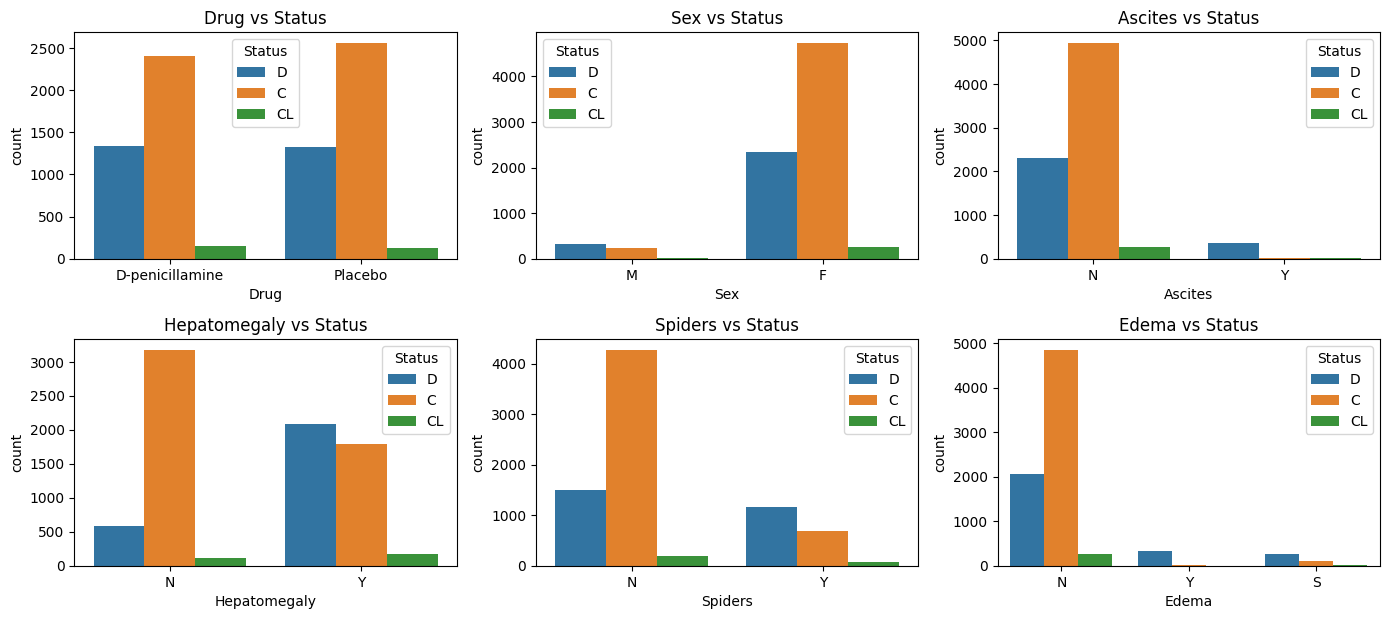

In [41]:
plt.figure(figsize=(14, len(CAT_FEATS) * 2))
for i, col in enumerate(CAT_FEATS):
    plt.subplot(len(CAT_FEATS) // 2 + 1, 3, i + 1)
    sns.countplot(x=col, hue=target, data=df_train)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()

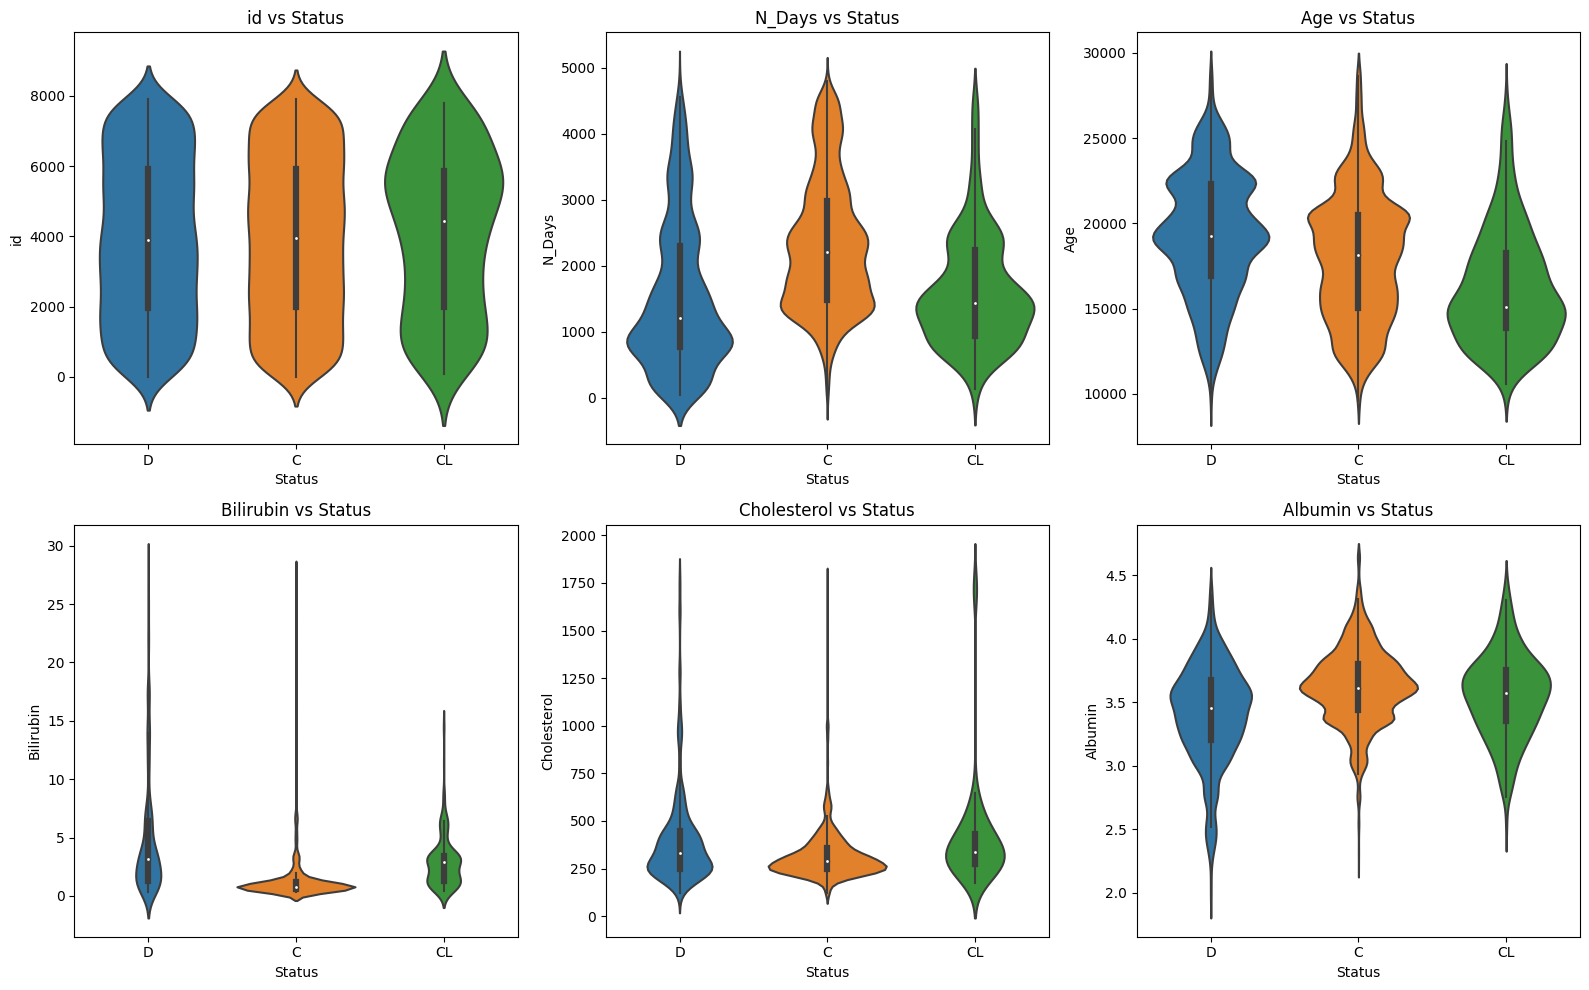

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    sns.violinplot(x=target, y=NUM_FEATS[i], data=df_train, ax=ax)
    # Set x ticks to be the original labels (inverse transform)
    ax.set_title(f"{NUM_FEATS[i]} vs {target}")
plt.tight_layout()
plt.show()

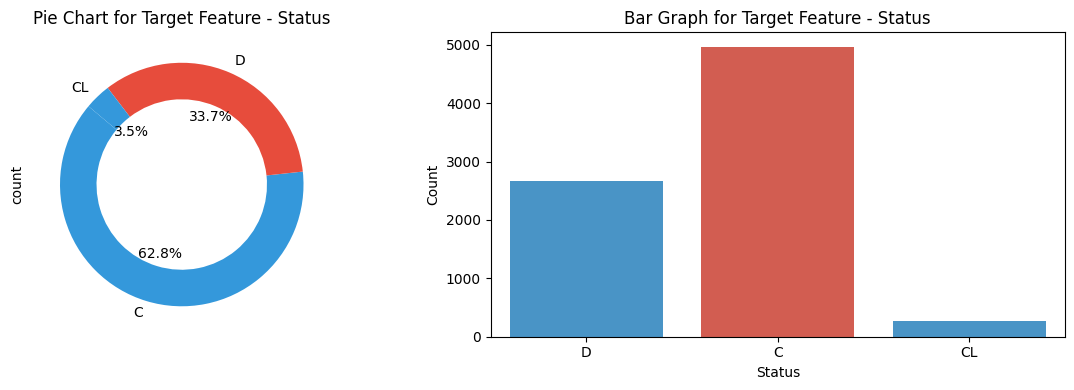

In [59]:
# Analysis of TARGET feature

# Define a custom color palette for categorical features
target_palette = ['#3498db', '#e74c3c']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie Chart
plt.subplot(1, 2, 1)
df_train[target].value_counts().plot.pie(autopct='%1.1f%%', colors=target_palette, wedgeprops=dict(width=0.3), startangle=140)
plt.title(f"Pie Chart for Target Feature - {target}")

# Bar Graph
plt.subplot(1, 2, 2)
sns.countplot(data=pd.concat([df_train]), x=target, palette=target_palette)
plt.ylabel("Count")
plt.title(f"Bar Graph for Target Feature - {target}")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

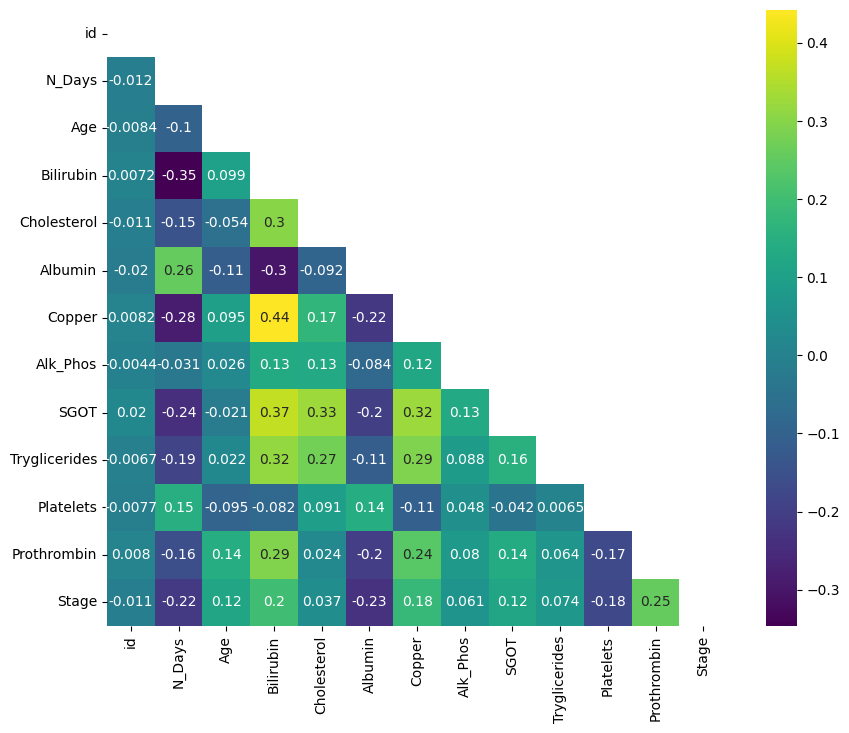

In [63]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df_train[NUM_FEATS].corr(), dtype=bool))
sns.heatmap(df_train[NUM_FEATS].corr(), annot=True, mask=mask, cmap='viridis')
plt.show()

<a name="4"></a>
# **<h1 id="4" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Data Processing</h1>**

In [44]:
# Encode all the categorical features
df_train_cat_encode = df_train[CAT_FEATS]
df_test_cat_encode= df_test[CAT_FEATS]

# Combine train and test datasets
df_combined = pd.concat([df_train_cat_encode, df_test_cat_encode], ignore_index=True)

# Perform one-hot encoding
df_combined_encoded = pd.get_dummies(df_combined, columns=CAT_FEATS, drop_first= True)

# Split back into train and test datasets
df_train_cat_encoded = df_combined_encoded.iloc[:len(df_train)]
df_test_cat_encoded = df_combined_encoded.iloc[len(df_train):]

In [45]:
# Scale all the numerical features
df_train_num_scale = df_train[NUM_FEATS]
df_test_num_scale = df_test[NUM_FEATS]

from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(df_train_num_scale)

# Scale the training data
df_train_num_scaled = minmax_scaler.transform(df_train_num_scale)
df_train_num_scaled = pd.DataFrame(df_train_num_scaled, columns=df_train_num_scale.columns)

# Scale the test data using the parameters from the training data
df_test_num_scaled = minmax_scaler.transform(df_test_num_scale)
df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=df_test_num_scale.columns)


In [46]:
# Concatenate datasets
df_train_combined = pd.concat([df_train_cat_encoded.reset_index(drop=True), df_train_num_scaled.reset_index(drop=True)], axis=1)
df_train_combined[target] = df_train[target]

# Concatenate test datasets
df_test_combined = pd.concat([df_test_cat_encoded.reset_index(drop=True), df_test_num_scaled.reset_index(drop=True)], axis=1)
df_test_combined

,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,False,True,False,False,False,False,False,0.000000,0.201515,0.626391,0.072202,0.118429,0.518657,0.287671,0.096660,0.356115,0.053097,0.662675,0.077778,0.666667
1,True,False,False,False,False,False,False,0.000127,0.532814,0.505931,0.021661,0.147432,0.589552,0.101027,0.084798,0.251799,0.097345,0.596806,0.222222,0.666667
2,True,False,False,True,True,False,True,0.000253,0.712453,0.216723,0.108303,0.108157,0.593284,0.217466,0.054518,0.215827,0.030088,0.273453,0.300000,1.000000
3,True,False,False,False,False,False,False,0.000380,0.533235,0.465148,0.010830,0.082175,0.574627,0.092466,0.100491,0.104317,0.111504,0.413174,0.188889,0.666667
4,True,False,False,True,False,False,False,0.000506,0.157131,0.370565,0.028881,0.136556,0.630597,0.101027,0.065717,0.230216,0.111504,0.471058,0.177778,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,False,False,False,False,False,False,False,0.999494,0.236643,0.380065,0.018051,0.114199,0.597015,0.058219,0.098723,0.122302,0.338053,0.562874,0.100000,0.333333
7901,True,False,False,True,False,False,False,0.999620,0.305217,0.390143,0.021661,0.084592,0.548507,0.099315,0.084798,0.268392,0.079646,0.429142,0.111111,1.000000
7902,False,False,False,False,True,True,False,0.999747,0.322886,0.854241,0.061372,0.063444,0.458955,0.080479,0.047446,0.100719,0.051327,0.275449,0.411111,0.333333
7903,False,True,False,True,False,False,False,0.999873,0.745267,0.701344,0.014440,0.077341,0.294776,0.047945,0.052603,0.071942,0.150442,0.317365,0.177778,1.000000


In [47]:
X = df_train_combined.drop(columns=[target])

y = df_train_combined[target]
le = LabelEncoder().fit(y)
y = pd.Series(le.transform(y))

<a name="5"></a>
# **<h1 id="5" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Model Building</h1>**

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier()

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.8336495888678052

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       966
           1       0.67      0.19      0.30        52
           2       0.83      0.73      0.78       563

    accuracy                           0.83      1581
   macro avg       0.78      0.62      0.65      1581
weighted avg       0.83      0.83      0.82      1581



<a name="6"></a>
# **<h1 id="6" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Finding Best paramaters With Optuna</h1>**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': len(set(y_train)),
        'eval_metric': 'mlogloss', 
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'n_estimators': trial.suggest_int("n_estimators",500,1500),
        'subsample': trial.suggest_uniform("subsample", 0.5, 0.8),
        'colsample_bytree': trial.suggest_uniform("colsample_bytree", 0.25, 0.8)
    }

    model = XGBClassifier(**params)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print(f'===========================================================================')
print('Best trial:')
xgb_params = study.best_params
print(f'===========================================================================')
print(f'xgboost parameters{xgb_params}')
print(f'===========================================================================')

[I 2024-02-09 10:00:17,386] A new study created in memory with name: no-name-000e04de-b3f0-49c8-b518-5c71c83ce96a


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-02-09 10:00:23,609] Trial 0 finished with value: 0.8368121442125237 and parameters: {'lambda': 0.12012118818162139, 'alpha': 1.760000427562632e-08, 'max_depth': 8, 'gamma': 1.539577160032538e-06, 'learning_rate': 0.012521855544082328, 'n_estimators': 1445, 'subsample': 0.5167160232430446, 'colsample_bytree': 0.769474741446469}. Best is trial 0 with value: 0.8368121442125237.
[I 2024-02-09 10:00:24,525] Trial 1 finished with value: 0.8387096774193549 and parameters: {'lambda': 0.3963944606924685, 'alpha': 0.0027650983231696036, 'max_depth': 3, 'gamma': 2.9898983868129383e-05, 'learning_rate': 0.0940783741645099, 'n_estimators': 1267, 'subsample': 0.6350189788416416, 'colsample_bytree': 0.7520554765507249}. Best is trial 1 with value: 0.8387096774193549.
[I 2024-02-09 10:00:29,752] Trial 2 finished with value: 0.8380771663504112 and parameters: {'lambda': 6.019444127952736e-08, 'alpha': 0.004401176979075431, 'max_depth': 3, 'gamma': 4.1903534479089603e-08, 'learning_rate': 0.0093

<a name="7"></a>
# **<h1 id="7" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Rebuilding Model With Optimized Paramaters</h1>**

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       966
           1       0.64      0.17      0.27        52
           2       0.85      0.75      0.79       563

    accuracy                           0.84      1581
   macro avg       0.78      0.62      0.65      1581
weighted avg       0.84      0.84      0.83      1581



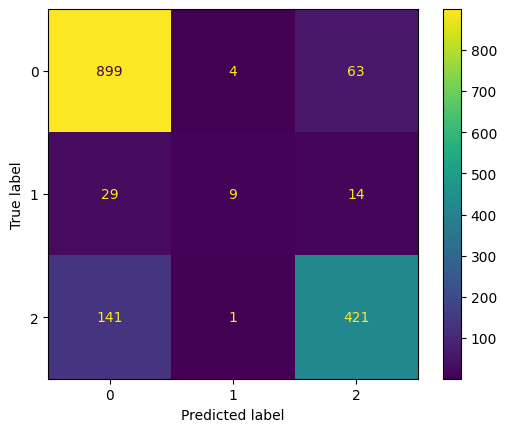

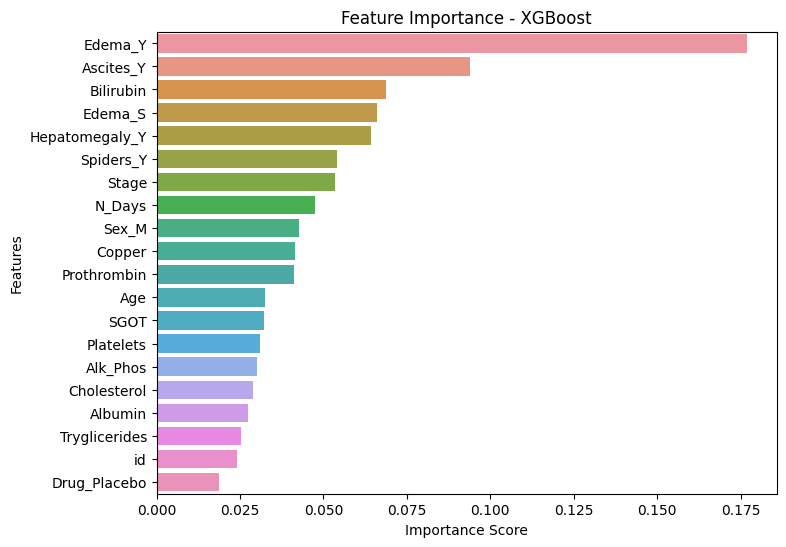

In [50]:
# Train the final XGBoost model with the best hyperparameters
best_model_xgb = XGBClassifier(**xgb_params)
best_model_xgb.fit(X_train, y_train)

y_pred = best_model_xgb.predict(X_test)
accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Plot feature importance for XGBoost
plt.figure(figsize=(8, 6))
feature_importance_xgb = pd.DataFrame({'Features': X.columns, 'Importance': best_model_xgb.feature_importances_})
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False)

feature_importance_xgb

sns.barplot(x='Importance', y='Features', data=feature_importance_xgb)
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

<a name="8"></a>
# **<h1 id="8" style="background-color:#2874A6;font-family:newtimeroman;font-size:150%;color:#FDFEFE;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #FDFEFE;">Prediction On Test Data</h1>**

In [51]:
predictions = best_model_xgb.predict_proba(df_test_combined)
predictions

array([[3.5999154e-03, 4.0090905e-04, 9.9599922e-01],
       [9.7556734e-01, 2.8317550e-04, 2.4149489e-02],
       [3.8622462e-03, 4.7983256e-05, 9.9608982e-01],
       ...,
       [6.3763382e-03, 2.6871421e-05, 9.9359679e-01],
       [9.5733446e-01, 1.0464234e-04, 4.2560820e-02],
       [9.9220735e-01, 5.1703315e-05, 7.7410042e-03]], dtype=float32)

In [52]:
submission = pd.DataFrame({"id": df_test['id'], "Status_C": predictions[:, 0], "Status_CL": predictions[:, 1], "Status_D": predictions[:, 2]})
submission

,id,Status_C,Status_CL,Status_D
0,0,0.003600,0.000401,0.995999
1,1,0.975567,0.000283,0.024149
2,2,0.003862,0.000048,0.996090
3,3,0.993180,0.000086,0.006734
4,4,0.983824,0.000611,0.015565
...,...,...,...,...
7900,7900,0.996502,0.000329,0.003169
7901,7901,0.969732,0.000773,0.029495
7902,7902,0.006376,0.000027,0.993597
7903,7903,0.957334,0.000105,0.042561
